# 实例：用随机森林回归填补缺失值
### 1.导入需要的库

In [1]:

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


### 2. 以波士顿数据集为例，导入完整的数据集并探索

In [7]:
dataset = load_boston()
dataset.data.shape
#总共506*13=6578个数据
X_full, y_full = dataset.data, dataset.target
n_samples = X_full.shape[0]
n_features = X_full.shape[1]
n_samples
n_features

(506, 13)

506

13

### 3. 为完整数据放入缺失值

In [20]:
#首先确定我们希望放入的缺失数据的比例，在这里我们假设是50%，那总共就要有3289个数据缺失
rng = np.random.RandomState(0)
missing_rate = 0.5
n_missing_samples = int(np.floor(n_samples * n_features * missing_rate))
n_missing_samples
#np.floor向下取整，返回.0格式的浮点数
#所有数据要随机遍布在数据集的各行各列当中，而一个缺失的数据会需要一个行索引和一个列索引
#如果能够创造一个数组，包含3289个分布在0~506中间的行索引，和3289个分布在0~13之间的列索引，那我们就可以利用索引来为数据中的任意3289个位置赋空值
#然后我们用0，均值和随机森林来填写这些缺失值，然后查看回归的结果如何
missing_features = rng.randint(0,n_features,n_missing_samples)
missing_samples = rng.randint(0,n_samples,n_missing_samples)
missing_features
missing_features.shape
missing_samples.shape
#missing_samples = rng.choice(dataset.data.shape[0],n_missing_samples,replace=False)
#我们现在采样了3289个数据，远远超过我们的样本量506，所以我们使用随机抽取的函数randint。
#但如果我们需要的数据量小于我们的样本量506，那我们可以采用np.random.choice来抽样，choice会随机抽取不重复的随机数，因此可以帮助我们让数据更加分散，确保数据不会集中在一些行中
X_missing = X_full.copy()
y_missing = y_full.copy()
X_missing[missing_samples,missing_features] = np.nan
X_missing
X_missing = pd.DataFrame(X_missing)
#转换成DataFrame是为了后续方便各种操作，numpy对矩阵的运算速度快到拯救人生，但是在索引等功能上却不如pandas来得好用
X_missing.head()

3289

array([12,  5,  0, ..., 11,  0,  2])

(3289,)

(3289,)

array([[       nan, 1.8000e+01,        nan, ...,        nan,        nan,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00,        nan, ...,        nan, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02,        nan, 7.0700e+00, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan, 1.1930e+01, ..., 2.1000e+01,        nan,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ...,        nan, 3.9690e+02,
        7.8800e+00]])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.2,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.9,4.9671,2.0,NaN,NaN,396.9,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.1,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,45.8,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,NaN,18.7,NaN,5.33


### 4. 使用0和均值填补缺失值

In [23]:
#使用均值进行填补
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_missing_mean = imp_mean.fit_transform(X_missing)
X_missing_mean

#使用0进行填补
imp_0 = SimpleImputer(missing_values=np.nan, strategy="constant",fill_value=0)
X_missing_0 = imp_0.fit_transform(X_missing)
X_missing_0


array([[3.62757895e+00, 1.80000000e+01, 1.11634641e+01, ...,
        1.85211921e+01, 3.52741952e+02, 4.98000000e+00],
       [2.73100000e-02, 0.00000000e+00, 1.11634641e+01, ...,
        1.85211921e+01, 3.96900000e+02, 9.14000000e+00],
       [2.72900000e-02, 1.07229508e+01, 7.07000000e+00, ...,
        1.85211921e+01, 3.52741952e+02, 1.29917666e+01],
       ...,
       [3.62757895e+00, 1.07229508e+01, 1.19300000e+01, ...,
        2.10000000e+01, 3.52741952e+02, 5.64000000e+00],
       [1.09590000e-01, 0.00000000e+00, 1.19300000e+01, ...,
        2.10000000e+01, 3.93450000e+02, 6.48000000e+00],
       [4.74100000e-02, 0.00000000e+00, 1.19300000e+01, ...,
        1.85211921e+01, 3.96900000e+02, 7.88000000e+00]])

array([[9.9990e+03, 1.8000e+01, 9.9990e+03, ..., 9.9990e+03, 9.9990e+03,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 9.9990e+03, ..., 9.9990e+03, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 9.9990e+03, 7.0700e+00, ..., 9.9990e+03, 9.9990e+03,
        9.9990e+03],
       ...,
       [9.9990e+03, 9.9990e+03, 1.1930e+01, ..., 2.1000e+01, 9.9990e+03,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 9.9990e+03, 3.9690e+02,
        7.8800e+00]])

### 5.使用随机森林填补缺失值
使用随机森林回归填补缺失值

任何回归都是从特征矩阵中学习，然后求解连续型标签y的过程，之所以能够实现这个过程，是因为回归算法认为，特征矩阵和标签之前存在着某种联系。实际上，标签和特征是可以相互转换的，比如说，在一个“用地区，环境，附近学校数量”预测“房价”的问题中，我们既可以用“地区”，“环境”，“附近学校数量”的数据来预测“房价”，也可以反过来，用“环境”，“附近学校数量”和“房价”来预测“地区”。而回归填补缺失值，正是利用了这种思想。

对于一个有n个特征的数据来说，其中特征T有缺失值，我们就把特征T当作标签，其他的n-1个特征和原本的标签组成新的特征矩阵。那对于T来说，它没有缺失的部分，就是我们的Y_test，这部分数据既有标签也有特征，而它缺失的部分，只有特征没有标签，就是我们需要预测的部分。

特征T不缺失的值对应的其他n-1个特征 + 本来的标签：X_train
特征T不缺失的值：Y_train

特征T缺失的值对应的其他n-1个特征 + 本来的标签：X_test
特征T缺失的值：未知，我们需要预测的Y_test

这种做法，对于某一个特征大量缺失，其他特征却很完整的情况，非常适用。

那如果数据中除了特征T之外，其他特征也有缺失值怎么办？
答案是遍历所有的特征，从缺失最少的开始进行填补（因为填补缺失最少的特征所需要的准确信息最少）。
填补一个特征时，先将其他特征的缺失值用0代替，每完成一次回归预测，就将预测值放到原本的特征矩阵中，再继续填补下一个特征。每一次填补完毕，有缺失值的特征会减少一个，所以每次循环后，需要用0来填补的特征就越来越少。当进行到最后一个特征时（这个特征应该是所有特征中缺失值最多的），已经没有任何的其他特征需要用0来进行填补了，而我们已经使用回归为其他特征填补了大量有效信息，可以用来填补缺失最多的特征。遍历所有的特征后，数据就完整，不再有缺失值了。


In [51]:
X_missing_reg = X_missing.copy()
X_missing_reg.isnull()
X_missing_reg.isnull().sum(axis=0)
np.sort(X_missing_reg.isnull().sum(axis=0))
np.argsort(X_missing_reg.isnull().sum(axis=0))
sortindex = np.argsort(X_missing_reg.isnull().sum(axis=0)).values

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,True,False,True,True,False,True,False,False,False,False,True,True,False
1,False,False,True,False,False,True,False,False,False,True,True,False,False
2,False,True,False,False,True,False,False,True,False,False,True,True,True
3,True,True,True,False,False,True,False,True,True,False,False,True,True
4,True,False,False,False,True,False,True,True,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,True,True,True,False,False,True,False,True,False,True,False,True,False
502,False,False,False,False,False,False,False,False,False,False,True,False,False
503,True,True,False,True,False,False,False,True,True,True,False,True,False
504,False,False,False,True,False,True,False,True,False,True,False,False,False


0     200
1     201
2     200
3     203
4     202
5     201
6     185
7     197
8     196
9     197
10    204
11    214
12    189
dtype: int64

array([185, 189, 196, 197, 197, 200, 200, 201, 201, 202, 203, 204, 214])

0      6
1     12
2      8
3      7
4      9
5      0
6      2
7      1
8      5
9      4
10     3
11    10
12    11
dtype: int64

In [52]:
# #以特征6举例。
# i=6
# #构建我们的新特征矩阵和新标签
# df = X_missing_reg
# #新标签
# fillc = df.iloc[:,i]
# fillc
# df = pd.concat([df.iloc[:,df.columns != i],pd.DataFrame(y_full)],axis=1)
# #在新特征矩阵中，对含有缺失值的列，进行0的填补
# df_0 =SimpleImputer(missing_values=np.nan,
# strategy='constant',fill_value=0).fit_transform(df)
# #找出我们的训练集和测试集
# Ytrain = fillc[fillc.notnull()]
# Ytest = fillc[fillc.isnull()]
# Xtrain = df_0[Ytrain.index,:]
# Xtest = df_0[Ytest.index,:]
# #用随机森林回归来填补缺失值
# rfc = RandomForestRegressor(n_estimators=100)
# rfc = rfc.fit(Xtrain, Ytrain)
# Ypredict = rfc.predict(Xtest)
# #将填补好的特征返回到我们的原始的特征矩阵中
# X_missing_reg.loc[X_missing_reg.iloc[:,i].isnull(),i] = Ypredict

In [53]:
for i in sortindex:
    #构建我们的新特征矩阵和新标签
    df = X_missing_reg
    fillc = df.iloc[:,i]
    df = pd.concat([df.iloc[:,df.columns != i],pd.DataFrame(y_full)],axis=1)
    #在新特征矩阵中，对含有缺失值的列，进行0的填补
    df_0 =SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0).fit_transform(df)
#     df_0 =SimpleImputer(missing_values=np.nan,strategy='mean').fit_transform(df)
    #找出我们的训练集和测试集
    Ytrain = fillc[fillc.notnull()]
    Ytest = fillc[fillc.isnull()]
    Xtrain = df_0[Ytrain.index,:]
    Xtest = df_0[Ytest.index,:]
    #用随机森林回归来填补缺失值
    rfc = RandomForestRegressor(n_estimators=100)
    rfc = rfc.fit(Xtrain, Ytrain)
    Ypredict = rfc.predict(Xtest)
    #将填补好的特征返回到我们的原始的特征矩阵中
    X_missing_reg.loc[X_missing_reg.iloc[:,i].isnull(),i] = Ypredict

In [54]:
X = [X_full,X_missing_mean,X_missing_0,X_missing_reg]
mse = []
std = []
for x in X:
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)
    scores = cross_val_score(estimator,x,y_full,scoring='neg_mean_squared_error',cv=5).mean()
    mse.append(scores * -1)

In [55]:
[*zip(["X_full","X_missing_mean","X_missing_0","X_missing_reg"],mse)]

[('X_full', 21.571667100368845),
 ('X_missing_mean', 40.848037216676374),
 ('X_missing_0', 47.45602386608426),
 ('X_missing_reg', 20.116748888118803)]

<Figure size 864x432 with 0 Axes>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

Text(0.5, 1.0, 'Imputation Techniques with Boston Data')

(18.105073999306924, 52.20162625269269)

Text(0.5, 0, 'MSE')

[Text(0, 0, 'Full data'),
 Text(0, 1, 'Zero Imputation'),
 Text(0, 2, 'Mean Imputation'),
 Text(0, 3, 'Regressor Imputation')]

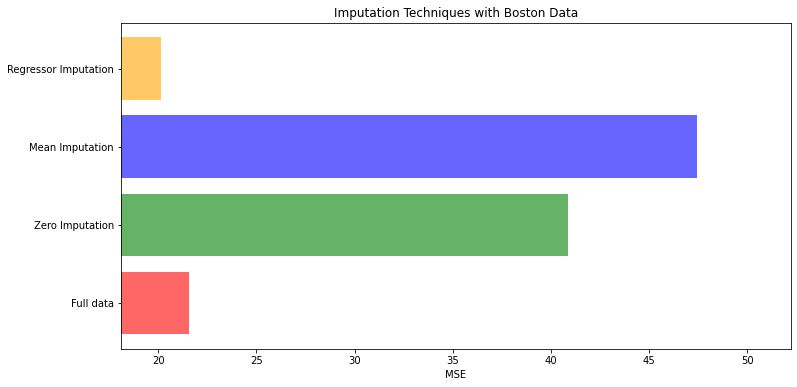

In [57]:
x_labels = ['Full data',
            'Zero Imputation',
            'Mean Imputation',
            'Regressor Imputation']
colors = ['r', 'g', 'b', 'orange']

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

for i in np.arange(len(mse)):
    ax.barh(i, mse[i],color=colors[i], alpha=0.6, align='center')
    
ax.set_title('Imputation Techniques with Boston Data')
ax.set_xlim(left=np.min(mse) * 0.9,right=np.max(mse) * 1.1)
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel('MSE')
# ax.invert_yaxis()
ax.set_yticklabels(x_labels)
plt.show()